<a href="https://colab.research.google.com/github/vagueau/Projet_python/blob/main/projet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [201]:
!pip install pyarrow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [202]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


IMPORTATION DES DONNEES

In [203]:
#from google.colab import drive
#drive.mount('/content/drive')

import pyarrow.parquet as pq

# Chemin du fichier Parquet
#chemin_fichier = "/content/yellow_tripdata_2023-03.parquet"
chemin_fichier = "yellow_tripdata_2023-03.parquet"

# Lecture du fichier Parquet
table = pq.read_table(chemin_fichier)

# Conversion de la table en DataFrame pandas
dataframe = table.to_pandas()

#dataframe.to_csv("format_csv.csv", index = False)
# Affichage des données
print(dataframe)



         VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0               2  2023-03-01 00:06:43   2023-03-01 00:16:43              1.0   
1               2  2023-03-01 00:08:25   2023-03-01 00:39:30              2.0   
2               1  2023-03-01 00:15:04   2023-03-01 00:29:26              0.0   
3               1  2023-03-01 00:49:37   2023-03-01 01:01:05              1.0   
4               2  2023-03-01 00:08:04   2023-03-01 00:11:06              1.0   
...           ...                  ...                   ...              ...   
3403761         2  2023-03-31 23:24:25   2023-03-31 23:40:54              NaN   
3403762         2  2023-03-31 23:24:50   2023-04-01 00:04:12              NaN   
3403763         2  2023-03-31 23:26:31   2023-03-31 23:49:39              NaN   
3403764         2  2023-03-31 23:07:51   2023-03-31 23:15:56              NaN   
3403765         2  2023-03-31 23:26:12   2023-03-31 23:31:47              NaN   

         trip_distance  Rat

In [204]:
import pandas as pd # bibliothèque de manipulation de données tabulaires
import numpy as np #  bibliothèque de manipulation des tableaux de données multidimensionnels
import matplotlib.pyplot as plt # bibliothèque de visualisation de données
import seaborn as sns #  bibliothèque de visualisation de données : graphiques statistiques

In [205]:
dataframe.head()


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2023-03-01 00:06:43,2023-03-01 00:16:43,1.0,0.00,1.0,N,238,42,2,8.6,1.0,0.5,0.00,0.0,1.0,11.10,0.0,0.00
1,2,2023-03-01 00:08:25,2023-03-01 00:39:30,2.0,12.40,1.0,N,138,231,1,52.7,6.0,0.5,12.54,0.0,1.0,76.49,2.5,1.25
2,1,2023-03-01 00:15:04,2023-03-01 00:29:26,0.0,3.30,1.0,N,140,186,1,18.4,3.5,0.5,4.65,0.0,1.0,28.05,2.5,0.00
3,1,2023-03-01 00:49:37,2023-03-01 01:01:05,1.0,2.90,1.0,N,140,43,1,15.6,3.5,0.5,4.10,0.0,1.0,24.70,2.5,0.00
4,2,2023-03-01 00:08:04,2023-03-01 00:11:06,1.0,1.23,1.0,N,79,137,1,7.2,1.0,0.5,2.44,0.0,1.0,14.64,2.5,0.00


In [206]:
dataframe.shape

(3403766, 19)

NETTOYAGE DES DONNEES
- suppression variables calculées dans le tarif

In [207]:
dataframe.isnull().sum()

VendorID                     0
tpep_pickup_datetime         0
tpep_dropoff_datetime        0
passenger_count          87619
trip_distance                0
RatecodeID               87619
store_and_fwd_flag       87619
PULocationID                 0
DOLocationID                 0
payment_type                 0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
improvement_surcharge        0
total_amount                 0
congestion_surcharge     87619
Airport_fee              87619
dtype: int64

variable à prédire : total_amount
pour la prédire : ne pas prendre en compte les autres variables monétaires
suppression de :     
- fare_amount
- extra
- mta_tax
- tip_amount
- tolls_amount
- improvement_surcharge
- congestion_surcharge
- airport_fee

In [208]:
df=dataframe.drop(['fare_amount', 'extra','mta_tax','tip_amount','tolls_amount','improvement_surcharge','congestion_surcharge','Airport_fee','RatecodeID'], axis=1)

In [209]:
df=df.drop(['VendorID', 'store_and_fwd_flag'], axis=1)

In [210]:
df.isnull().sum()

tpep_pickup_datetime         0
tpep_dropoff_datetime        0
passenger_count          87619
trip_distance                0
PULocationID                 0
DOLocationID                 0
payment_type                 0
total_amount                 0
dtype: int64

suppression des lignes vides pour maximiser la modélisation

In [211]:
moy=int(df['passenger_count'].mean())

In [212]:
df['passenger_count'] = df['passenger_count'].replace(np.nan, moy) #remplacement par la moyenne du nbre de passager 

In [213]:
#df=df.dropna(subset=['passenger_count'],axis=0) #suppression des lignes

In [214]:
df.isnull().sum()

tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
PULocationID             0
DOLocationID             0
payment_type             0
total_amount             0
dtype: int64

CREATION DE VARIABLES
Détails des dates  :    
- mois
- jour
- année
- heures
- minutes
- jour de la semaine
- durée du trajet

In [215]:
df['mois'] = df.tpep_pickup_datetime.dt.month
df['jour'] = df.tpep_pickup_datetime.dt.day
df['annee'] = df.tpep_pickup_datetime.dt.year
df['heure'] = df.tpep_pickup_datetime.dt.hour
df['minute'] = df.tpep_pickup_datetime.dt.minute
df['joursemaine'] = df.tpep_pickup_datetime.dt.weekday

df['durée']=(df['tpep_dropoff_datetime']-df['tpep_pickup_datetime'])
total_seconds = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds()
minutes = total_seconds // 60
seconds = total_seconds % 60
df['durée2'] = minutes + seconds / 60

# Arrondir à 2 décimales si nécessaire
df['durée2'] = df['durée2'].apply(lambda x: round(x, 2))

In [243]:
df=df.drop(['tpep_pickup_datetime','tpep_dropoff_datetime'], axis=1) #décomposation ok donc plus besoin des variables complètes

In [244]:
df.tail(10)

,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,total_amount,mois,jour,annee,heure,minute,joursemaine,durée,durée2
3403756,1.0,5.17,113,151,0,41.25,3,31,2023,23,43,4,0 days 00:25:49,25.82
3403757,1.0,1.57,45,79,0,15.41,3,31,2023,23,21,4,0 days 00:10:16,10.27
3403758,1.0,5.52,230,223,0,36.94,3,31,2023,23,44,4,0 days 00:33:00,33.00
3403759,1.0,2.48,74,141,0,15.27,3,31,2023,23,13,4,0 days 00:12:00,12.00
3403760,1.0,4.56,231,80,0,27.58,3,31,2023,23,11,4,0 days 00:20:17,20.28
3403761,1.0,3.16,163,75,0,20.36,3,31,2023,23,24,4,0 days 00:16:29,16.48
3403762,1.0,6.89,125,198,0,53.90,3,31,2023,23,24,4,0 days 00:39:22,39.37
3403763,1.0,4.01,50,224,0,28.02,3,31,2023,23,26,4,0 days 00:23:08,23.13
3403764,1.0,1.31,113,158,0,16.01,3,31,2023,23,7,4,0 days 00:08:05,8.08
3403765,1.0,0.88,41,166,0,17.26,3,31,2023,23,26,4,0 days 00:05:35,5.58


In [217]:
df.describe()

,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,total_amount,mois,jour,annee,heure,minute,joursemaine,durée,durée2
count,3.403766e+06,3.403766e+06,3.403766e+06,3.403766e+06,3.403766e+06,3.403766e+06,3.403766e+06,3.403766e+06,3.403766e+06,3.403766e+06,3.403766e+06,3.403766e+06,3403766,3.403766e+06
mean,1.342371e+00,3.903871e+00,1.654540e+02,1.641003e+02,1.187310e+00,2.780343e+01,3.000007e+00,1.588435e+01,2.023000e+03,1.434281e+01,2.954385e+01,3.026332e+00,0 days 00:16:52.909035462,1.688182e+01
std,8.764800e-01,1.916866e+02,6.373958e+01,6.967282e+01,5.334025e-01,2.286614e+01,1.316577e-02,8.984603e+00,3.455810e-02,5.760345e+00,1.734014e+01,1.847898e+00,0 days 00:43:47.674722006,4.379458e+01
min,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,-9.829500e+02,1.000000e+00,1.000000e+00,2.001000e+03,0.000000e+00,0.000000e+00,0.000000e+00,-1 days +16:03:45,-4.762500e+02
25%,1.000000e+00,1.050000e+00,1.320000e+02,1.140000e+02,1.000000e+00,1.570000e+01,3.000000e+00,8.000000e+00,2.023000e+03,1.100000e+01,1.400000e+01,2.000000e+00,0 days 00:07:24,7.400000e+00
50%,1.000000e+00,1.790000e+00,1.620000e+02,1.620000e+02,1.000000e+00,2.060000e+01,3.000000e+00,1.600000e+01,2.023000e+03,1.500000e+01,3.000000e+01,3.000000e+00,0 days 00:12:09,1.215000e+01
75%,1.000000e+00,3.380000e+00,2.330000e+02,2.340000e+02,1.000000e+00,2.976000e+01,3.000000e+00,2.400000e+01,2.023000e+03,1.900000e+01,4.500000e+01,4.000000e+00,0 days 00:19:39,1.965000e+01
max,9.000000e+00,2.169870e+05,2.650000e+02,2.650000e+02,5.000000e+00,2.100000e+03,1.200000e+01,3.100000e+01,2.023000e+03,2.300000e+01,5.900000e+01,6.000000e+00,3 days 21:57:43,5.637720e+03


RECHERCHE VALEURS ABERRANTES

In [218]:
from datetime import timedelta

variable 'durée'

In [219]:
df['durée'].max()

Timedelta('3 days 21:57:43')

In [220]:
oneday=timedelta(days=1)

In [221]:
(df['durée']>oneday).value_counts()

False    3403745
True          21
Name: durée, dtype: int64

In [222]:
df[df['durée']>oneday].value_counts()

tpep_pickup_datetime  tpep_dropoff_datetime  passenger_count  trip_distance  PULocationID  DOLocationID  payment_type  total_amount  mois  jour  annee  heure  minute  joursemaine  durée            durée2 
2023-03-03 12:53:19   2023-03-06 11:41:21    1.0              40.02          138           193           2             277.45        3     3     2023   12     53      4            2 days 22:48:02  4248.03    1
2023-03-19 17:59:13   2023-03-21 12:37:03    1.0              3.13           161           79            2             22.40         3     19    2023   17     59      6            1 days 18:37:50  2557.83    1
2023-03-26 15:18:05   2023-03-28 09:08:24    1.0              0.00           141           141           2             7.00          3     26    2023   15     18      6            1 days 17:50:19  2510.32    1
2023-03-24 23:09:55   2023-03-27 11:00:45    2.0              1.31           68            170           2             20.30         3     24    2023   23     9     

In [223]:
#df=df.drop(df[df['durée']>oneday], axis=0)
df.drop(df[(df['durée']>oneday)].index, inplace=True)

In [224]:
df['durée'].max()

Timedelta('0 days 23:59:48')

In [248]:
df=df.drop(['durée'], axis=1)

In [225]:
df.shape

(3403745, 16)

variable 'trip_distance'

In [226]:
df['trip_distance'].mean()

3.903870701242307

In [227]:
df['trip_distance'].max()

216986.96

In [228]:
df[df['trip_distance']>1000].value_counts()

tpep_pickup_datetime  tpep_dropoff_datetime  passenger_count  trip_distance  PULocationID  DOLocationID  payment_type  total_amount  mois  jour  annee  heure  minute  joursemaine  durée            durée2
2023-03-01 04:42:00   2023-03-01 04:59:00    1.0              9385.19        151           234           0             25.61         3     1     2023   4      42      2            0 days 00:17:00  17.00     1
2023-03-18 20:32:00   2023-03-18 20:52:00    1.0              16987.14       87            164           0             30.94         3     18    2023   20     32      5            0 days 00:20:00  20.00     1
2023-03-23 07:32:00   2023-03-23 07:58:00    1.0              12858.71       24            137           0             34.80         3     23    2023   7      32      3            0 days 00:26:00  26.00     1
2023-03-22 05:05:00   2023-03-22 05:19:00    1.0              6378.99        236           138           0             53.09         3     22    2023   5      5       2 

In [229]:
(df['trip_distance']>1000).value_counts()

False    3403650
True          95
Name: trip_distance, dtype: int64

In [230]:
df.drop(df[(df['trip_distance']>1000)].index, inplace=True)

In [238]:
df.shape

(3403650, 16)

DESCRIPTION STATISTIQUE DES DONNEES

In [245]:
df.dtypes

passenger_count            float64
trip_distance              float64
PULocationID                 int32
DOLocationID                 int32
payment_type                 int64
total_amount               float64
mois                         int64
jour                         int64
annee                        int64
heure                        int64
minute                       int64
joursemaine                  int64
durée              timedelta64[ns]
durée2                     float64
dtype: object

In [232]:
df['passenger_count'].value_counts()

1.0    2613657
2.0     479136
3.0     117805
4.0      59013
0.0      58365
5.0      46482
6.0      29171
8.0         11
7.0          7
9.0          3
Name: passenger_count, dtype: int64

<Axes: >

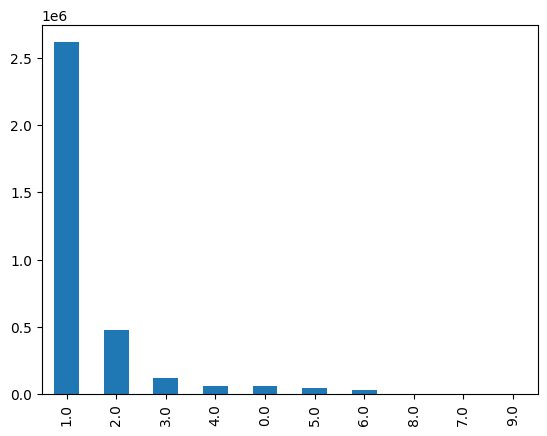

In [233]:
df['passenger_count'].value_counts().plot.bar()

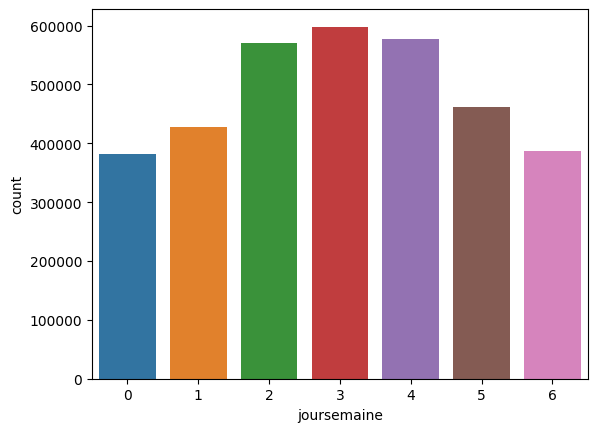

In [234]:
sns.countplot(x='joursemaine', data=df)
plt.show()

In [235]:
df['total_amount'].mean()

27.803345584886824

In [236]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3403650 entries, 0 to 3403765
Data columns (total 16 columns):
 #   Column                 Dtype          
---  ------                 -----          
 0   tpep_pickup_datetime   datetime64[ns] 
 1   tpep_dropoff_datetime  datetime64[ns] 
 2   passenger_count        float64        
 3   trip_distance          float64        
 4   PULocationID           int32          
 5   DOLocationID           int32          
 6   payment_type           int64          
 7   total_amount           float64        
 8   mois                   int64          
 9   jour                   int64          
 10  annee                  int64          
 11  heure                  int64          
 12  minute                 int64          
 13  joursemaine            int64          
 14  durée                  timedelta64[ns]
 15  durée2                 float64        
dtypes: datetime64[ns](2), float64(4), int32(2), int64(7), timedelta64[ns](1)
memory usage: 415

Jeux de données : entrainement et test

In [ ]:
from sklearn.model_selection import train_test_split

In [250]:
x=df.drop('total_amount', axis=1)
x

,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,mois,jour,annee,heure,minute,joursemaine,durée2
0,1.0,0.00,238,42,2,3,1,2023,0,6,2,10.00
1,2.0,12.40,138,231,1,3,1,2023,0,8,2,31.08
2,0.0,3.30,140,186,1,3,1,2023,0,15,2,14.37
3,1.0,2.90,140,43,1,3,1,2023,0,49,2,11.47
4,1.0,1.23,79,137,1,3,1,2023,0,8,2,3.03
...,...,...,...,...,...,...,...,...,...,...,...,...
3403761,1.0,3.16,163,75,0,3,31,2023,23,24,4,16.48
3403762,1.0,6.89,125,198,0,3,31,2023,23,24,4,39.37
3403763,1.0,4.01,50,224,0,3,31,2023,23,26,4,23.13
3403764,1.0,1.31,113,158,0,3,31,2023,23,7,4,8.08


In [251]:
y=df['total_amount']
y

0          11.10
1          76.49
2          28.05
3          24.70
4          14.64
           ...  
3403761    20.36
3403762    53.90
3403763    28.02
3403764    16.01
3403765    17.26
Name: total_amount, Length: 3403650, dtype: float64

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2)

**MODELISATION**

Régression linéaire 

In [252]:
from sklearn.linear_model import LinearRegression
myreg = LinearRegression()

myreg = myreg.fit(x,y)

ValueError: ignored

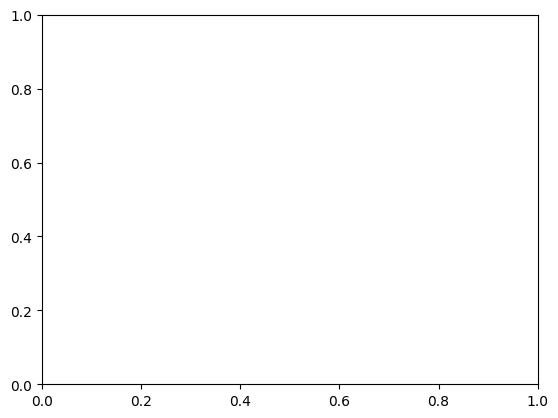

In [253]:
plt.scatter(x,y,c="orange") ; plt.plot(x,myreg.predict(x),"-r",color="#D42D85", linewidth=10) ; plt.xlabel("Poids") ; plt.ylabel("IMC") ; plt.show()

Réseaux de neurones

Support Vector Machine